# Factor Analysis and Shared vs. Individual Variance on Perturbation Task

April 11, 2022

Athalye et al. 2017 reported changes in shared vs. private variance during long term learning (2 weeks), while Zippi et al. 2021 showed Factor Analysis differences between direct and indirect neurons

I wanted to approach some of these findings by applying Factor Analysis to different scenarios.

I tried experimenting with the VMR task in `FactorAnalysis-VMR-2022-4-9.ipynb`, and found that learning W_fb usually did not lead to a change in Factor Analysis shared or private variance. I was hoping that there would be some difference between RFLO and REINFORCE with regards to shared vs. private variance, but I did not see this consistently with the VMR task.

In this notebook, I am applying the same approach, but with a perturbed decoder.

1. Pretrain
2. Change Decoder
3. Train with RFLO or REINFORCE

(either W_fb or W_rec)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# analysis
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.linear_model import LinearRegression
from scipy import stats, interpolate
from scipy import linalg as LA
from scipy.ndimage.filters import uniform_filter1d

# miscellaneous
from tqdm import tqdm
from itertools import cycle
from copy import deepcopy

import logging
import warnings
import dataclasses
from dataclasses import dataclass
from typing import Optional, List

import sys
sys.path.append("..")

In [2]:
from rnn import RNNparams, RNN
from task import Task
from simulation import Simulation
from algorithms.bptt import BPTT
from algorithms.rflo import RFLO
from algorithms.reinforce import REINFORCE
from algorithms.track_vars import TrackVars

from utils.plotting import plot_trained_trajectories
from utils.metric import cos_sim, return_norm_and_angle
from utils.functions import choose_aligned_matrix

In [3]:
def factor_analysis(sim,delta=10,n_components=2):
    
    """
    Apply Factor Analysis to RNN Simulation Data
    
    Args
    ----
    sim: simulation object
    delta (int): how many trials to bin together for factor analysis
    n_components (int): components for factor analysis
    """

    pr=[]
    sh=[]
    sot=[]

    # chunk into blocks
    for i in np.arange(0,len(sim.session_probes['h']),delta):
        h_ = sim.session_probes['h'][i:i+delta]
        dim1=h_[0].shape[0] # number of steps in trial
        dim2=h_[0].shape[1] # number of neurons

        h = np.asarray(h_).squeeze().reshape(dim1*delta,dim2)
        fa = FactorAnalysis(n_components=n_components, random_state=0)
        fa.fit(h.squeeze()) # X array-like, shape (n_samples, n_features)

        private = np.sum(fa.noise_variance_)
        shared = np.sum(np.diag(np.dot(fa.components_,fa.components_.T)))

        pr.append(private)
        sh.append(shared)
        sot.append(shared/(private+shared))
    
    return pr, sh, sot

### Train RNN on four targets

In [4]:
trial_duration = 20
n_in=4
frac_on = 0.2

x_tonic = 0.0*np.ones((trial_duration, n_in)) # shape 20 x 4 i.e. time x channel
x_pulse1 = x_tonic.copy()
x_pulse2 = x_tonic.copy()
x_pulse3 = x_tonic.copy()
x_pulse4 = x_tonic.copy()
x_pulse1[0:int(trial_duration*frac_on),0] = 1
x_pulse2[0:int(trial_duration*frac_on),1] = 1
x_pulse3[0:int(trial_duration*frac_on),2] = 1
x_pulse4[0:int(trial_duration*frac_on),3] = 1

task1 = Task(x_in=x_pulse1,y_target=np.asarray([[1],[1]]))
task2 = Task(x_in=x_pulse2,y_target=np.asarray([[-1],[1]]))
task3 = Task(x_in=x_pulse3,y_target=np.asarray([[1],[-1]]))
task4 = Task(x_in=x_pulse4,y_target=np.asarray([[-1],[-1]]))

### RFLO and REINFORCE with the same parameters

21it [00:00, 202.72it/s]

n_in: 4
n_rec: 50
n_out: 2
sig_in: 0.0
sig_rec: 0.25
sig_out: 0.01
tau_rec: 10
eta_in: 0.1
eta_rec: 0.25
eta_out: 0.1
g_in: 2.0
g_rec: 1.5
g_out: 2.0
g_fb: 2.0
driving_feedback: True
eta_fb: 0.1
sig_fb: 0.01
feedback_signal: position
velocity_transform: True
tau_vel: 0.8
dt_vel: 0.1
sig_rec_dim: None
eta_m: None
sig_m: None
lam_m: None
rng: <mtrand.RandomState object at 0x7f9d5aff35e8>


1000it [00:02, 424.57it/s]


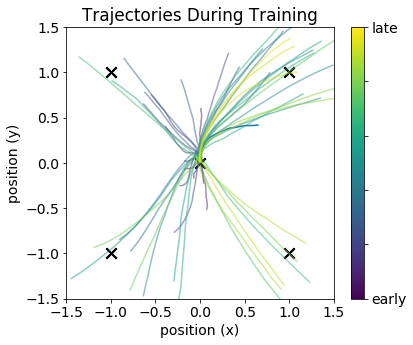

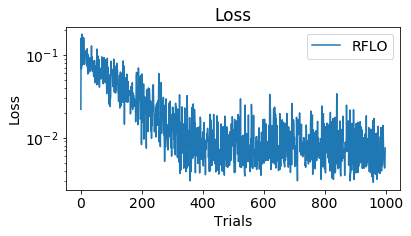

In [14]:
# Set RNN Parameters

params = RNNparams(n_in=4,n_rec=50,n_out=2,tau_rec=10,
               eta_in=0.1,eta_rec=0.25,eta_out=0.1,eta_fb=0.1,
               sig_in=0.0,sig_rec=0.25,sig_out=0.01, sig_fb=0.01,
               velocity_transform=True, tau_vel = 0.8, dt_vel = 0.1,
               driving_feedback=True,
               rng=np.random.RandomState(1776))
params.print_params()


# Initialize RNN
net0 = RNN(params)
sim0 = Simulation(net0)
rflo = RFLO(net0,apply_to=['w_rec'],online=False) 
sim0.run_session(n_trials=1000, tasks=[task1,task2,task3,task4], learn_alg=[rflo], probe_types=['h','loss'], plot=True, plot_freq=20)




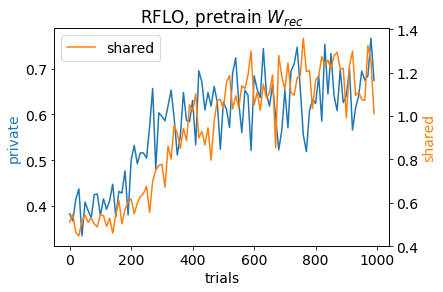

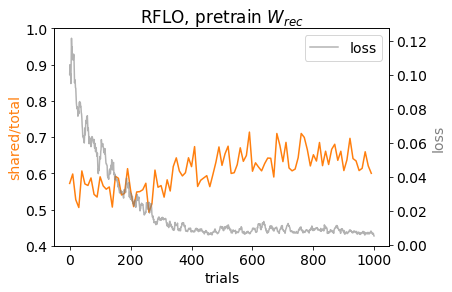

In [15]:
delta=10
pr, sh, sot = factor_analysis(sim0,delta=delta,n_components=2)

x = np.arange(0,len(sim0.session_probes['h']),delta)

fig,ax = plt.subplots(1,1)
ax1=ax.twinx()
av_pr = uniform_filter1d(pr,1)
ax.plot(x,av_pr,label='private',color='C0')
ax.set_ylabel('private',color='C0')

av_sh = uniform_filter1d(sh,1)
ax1.plot(x,av_sh,label='shared',color='C1')
ax1.set_ylabel('shared',color='C1')
ax.set_xlabel('trials')
ax1.legend()
plt.title('RFLO, pretrain '+r'$W_{rec}$')
plt.show()

fig,ax = plt.subplots(1,1)

ax1=ax.twinx()
ls = np.mean(np.asarray(sim0.session_probes['loss']),axis=1)
av_ls = uniform_filter1d(ls,delta)
ax1.plot(av_ls,label='loss',color='grey',alpha=0.6)
ax1.set_ylabel('loss',color='grey')
#av_sot = uniform_filter1d(sot,25)
ax.plot(x,sot,color='C1',alpha=1)
#ax.plot(av_sot,label='SOT',color='C1')
ax.set_ylabel('shared/total',color='C1')
ax.set_xlabel('trials')
ax.set_ylim([0.4,1])
ax1.legend()


plt.title('RFLO, pretrain '+r'$W_{rec}$')
plt.show()

In [14]:
np.asarray(sim0.session_probes['loss']).shape

(3000, 20)

# Change Readout

In [16]:
overlap = 0.6 # 0.6
n_change = 40 # 50
seed = 111
w_out1 = choose_aligned_matrix(net0.w_out.copy(),n_change=n_change,overlap=overlap,rng=np.random.RandomState(seed),zero=False,tolerance=0.01,loop=1000)


M norm: 1.43	 M angle: 0.61, 54 iterations

45it [00:00, 448.69it/s]

apply_to :  ['w_fb']
online :  True
weight_transport :  True


5000it [00:08, 565.10it/s]


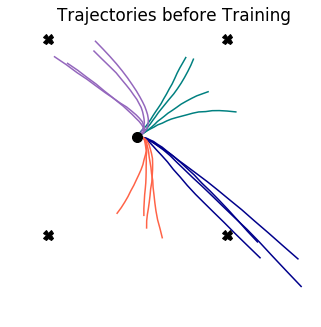

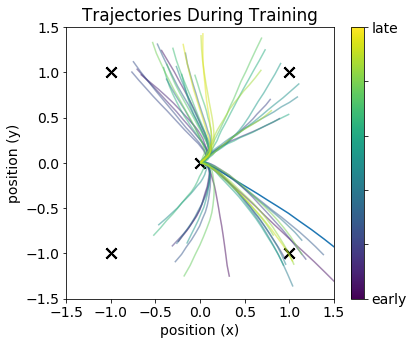

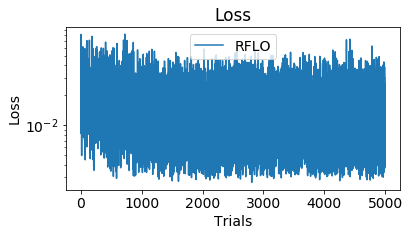

In [17]:
# Set RNN Parameters


# Initialize RNN
net1 = RNN(params)
net1.set_weights(w_in=net0.w_in.copy(), w_rec=net0.w_rec.copy())
net1.set_weights(w_out=w_out1,w_m=w_out1.T,w_fb=w_out1.T)
sim1 = Simulation(net1)

fig = plot_trained_trajectories(sim=sim1, tasks=[task1,task2,task3,task4],title='Trajectories before Training')

rflo = RFLO(net1,apply_to=['w_fb']) 
rflo.print_params()
sim1.run_session(n_trials=5000, tasks=[task1,task2,task3,task4], learn_alg=[rflo], probe_types=['h','loss'], plot=True, plot_freq=100)


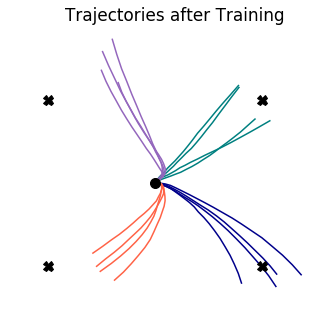

In [18]:
fig = plot_trained_trajectories(sim=sim1, tasks=[task1,task2,task3,task4],title='Trajectories after Training')


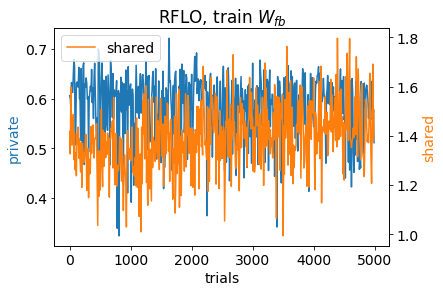

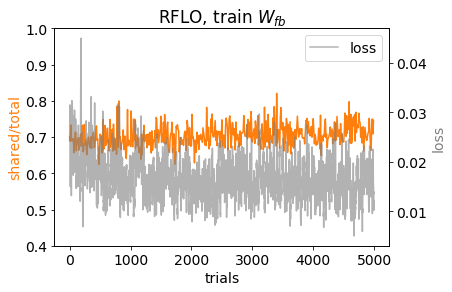

In [19]:
delta=10
pr, sh, sot = factor_analysis(sim1,delta=delta,n_components=2)

x = np.arange(0,len(sim1.session_probes['h']),delta)

fig,ax = plt.subplots(1,1)
ax1=ax.twinx()
av_pr = uniform_filter1d(pr,1)
ax.plot(x,av_pr,label='private',color='C0')
ax.set_ylabel('private',color='C0')

av_sh = uniform_filter1d(sh,1)
ax1.plot(x,av_sh,label='shared',color='C1')
ax1.set_ylabel('shared',color='C1')
ax.set_xlabel('trials')
ax1.legend()
plt.title('RFLO, train '+r'$W_{fb}$')
plt.show()

fig,ax = plt.subplots(1,1)

ax1=ax.twinx()
ls = np.mean(np.asarray(sim1.session_probes['loss']),axis=1)
av_ls = uniform_filter1d(ls,delta)
ax1.plot(av_ls,label='loss',color='grey',alpha=0.6)
ax1.set_ylabel('loss',color='grey')

ax.plot(x,sot,color='C1',alpha=1)
ax.set_ylabel('shared/total',color='C1')
ax.set_xlabel('trials')
ax.set_ylim([0.4,1])
ax1.legend()


plt.title('RFLO, train '+r'$W_{fb}$')
plt.show()

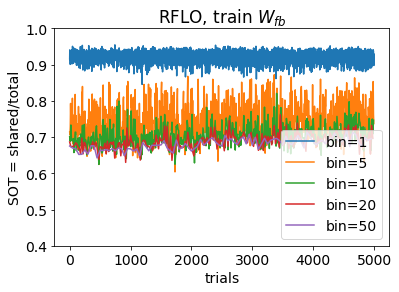

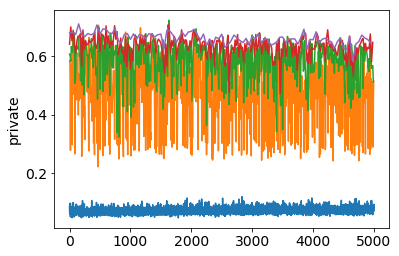

In [20]:
fig0,ax0 = plt.subplots(1,1)
fig1,ax1 = plt.subplots(1,1)

deltas = [1,5,10,20,50]

for delta in deltas:
    pr, sh, sot = factor_analysis(sim1,delta=delta,n_components=2)
    
    av_sot = uniform_filter1d(sot,1)
    x = np.arange(0,len(sim1.session_probes['h']),delta)
    ax0.plot(x,av_sot,label='bin={}'.format(delta),alpha=1)
    ax0.set_ylim([0.4,1]) 
    
    ax1.plot(x,pr,label='bin={}'.format(delta),alpha=1)
    #ax1.set_ylim([0.6,1])



ax0.set_ylabel('SOT = shared/total')
ax1.set_ylabel('private')

for ax in [ax0,ax1]:
    ax.set_xlabel('trials')
    ax.legend()
    ax.set_title('RFLO, train '+r'$W_{fb}$')
    plt.show()

## RFLO, Train W_rec

31it [00:00, 295.31it/s]

apply_to :  ['w_rec']
online :  True
weight_transport :  True


1500it [00:05, 268.41it/s]


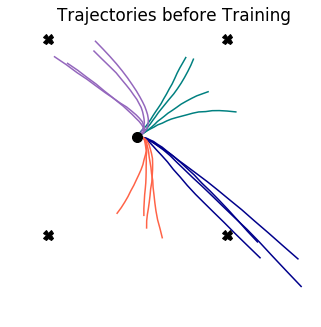

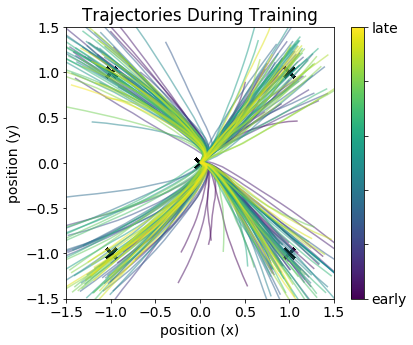

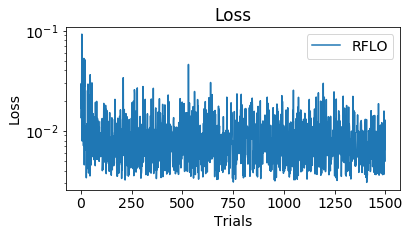

In [21]:

# Initialize RNN
net2 = RNN(params)
net2.set_weights(w_in=net0.w_in.copy(), w_rec=net0.w_rec.copy())#,w_fb=net0.w_fb.copy())
net2.set_weights(w_out=w_out1,w_m=w_out1.T,w_fb=w_out1.T)
sim2 = Simulation(net2)

fig = plot_trained_trajectories(sim=sim2, tasks=[task1,task2,task3,task4],title='Trajectories before Training')


rflo = RFLO(net2,apply_to=['w_rec']) 
rflo.print_params()
sim2.run_session(n_trials=1500, tasks=[task1,task2,task3,task4], learn_alg=[rflo], probe_types=['h','y_out','pos','loss'], plot=True, plot_freq=5)


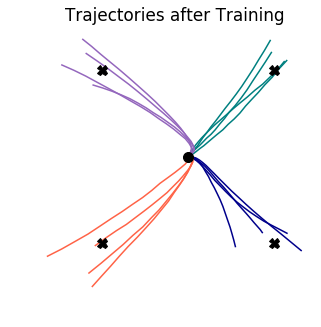

In [22]:
fig = plot_trained_trajectories(sim=sim2, tasks=[task1,task2,task3,task4],title='Trajectories after Training')


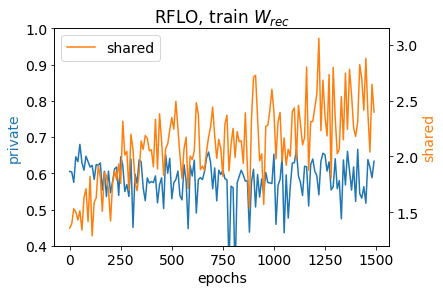

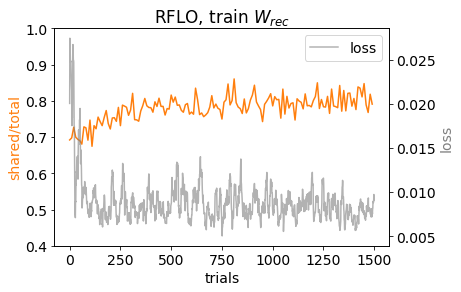

In [23]:
delta=10
pr, sh, sot = factor_analysis(sim2,delta=delta,n_components=2)


x = np.arange(0,len(sim2.session_probes['h']),delta)


fig,ax = plt.subplots(1,1)
ax1=ax.twinx()
av_pr = uniform_filter1d(pr,1)
ax.plot(x,av_pr,label='private',color='C0')
ax.set_ylabel('private',color='C0')

av_sh = uniform_filter1d(sh,1)
ax1.plot(x,av_sh,label='shared',color='C1')
ax1.set_ylabel('shared',color='C1')
ax.set_xlabel('epochs')
ax.set_ylim([0.4,1])
ax1.legend()

plt.title('RFLO, train '+r'$W_{rec}$')
plt.show()



fig,ax = plt.subplots(1,1)

ax1=ax.twinx()
ls = np.mean(np.asarray(sim2.session_probes['loss']),axis=1)
av_ls = uniform_filter1d(ls,delta)
ax1.plot(av_ls,label='loss',color='grey',alpha=0.6)
ax1.set_ylabel('loss',color='grey')

ax.plot(x,sot,color='C1',alpha=1)
ax.set_ylabel('shared/total',color='C1')
ax.set_xlabel('trials')
ax.set_ylim([0.4,1])
ax1.legend()


plt.title('RFLO, train '+r'$W_{rec}$')
plt.show()

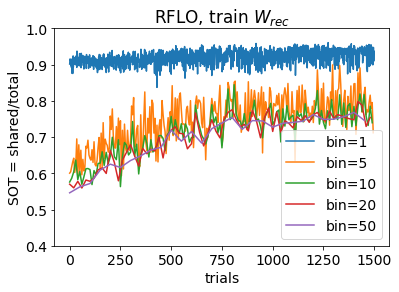

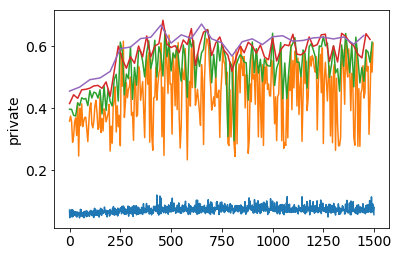

In [13]:
fig0,ax0 = plt.subplots(1,1)
fig1,ax1 = plt.subplots(1,1)

deltas = [1,5,10,20,50]

for delta in deltas:
    pr, sh, sot = factor_analysis(sim2,delta=delta,n_components=2)
    
    av_sot = uniform_filter1d(sot,1)
    x = np.arange(0,len(sim2.session_probes['h']),delta)
    ax0.plot(x,av_sot,label='bin={}'.format(delta),alpha=1)
    ax0.set_ylim([0.4,1]) 
    
    ax1.plot(x,pr,label='bin={}'.format(delta),alpha=1)
    #ax1.set_ylim([0.6,1])



ax0.set_ylabel('SOT = shared/total')
ax1.set_ylabel('private')

for ax in [ax0,ax1]:
    ax.set_xlabel('trials')
    ax.legend()
    ax.set_title('RFLO, train '+r'$W_{rec}$')
    plt.show()

# REINFORCE, train W_fb

18it [00:00, 177.87it/s]

n_in: 4
n_rec: 50
n_out: 2
sig_in: 0.0
sig_rec: 0.25
sig_out: 0.01
tau_rec: 10
eta_in: 0.1
eta_rec: 0.25
eta_out: 0.1
g_in: 2.0
g_rec: 1.5
g_out: 2.0
g_fb: 2.0
driving_feedback: True
eta_fb: 0.1
sig_fb: 0.01
feedback_signal: position
velocity_transform: True
tau_vel: 0.8
dt_vel: 0.1
sig_rec_dim: None
eta_m: None
sig_m: None
lam_m: None
rng: <mtrand.RandomState object at 0x7f95c2657990>
apply_to :  ['w_fb']
online :  True


50000it [02:13, 373.21it/s]


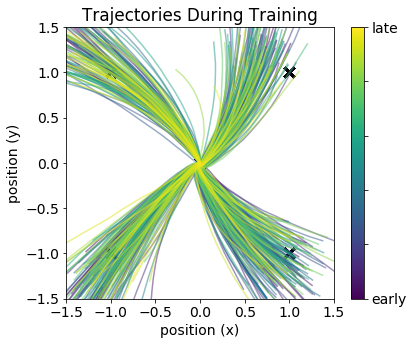

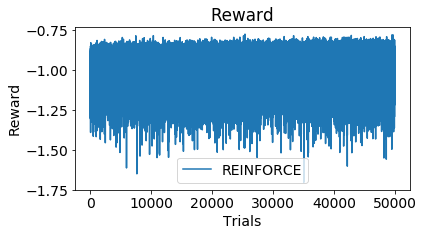

In [38]:
# Initialize RNN
params.print_params()
net4 = RNN(params)
net4.set_weights(w_in=net0.w_in.copy(), w_rec=net0.w_rec.copy())#,w_fb=net0.w_fb.copy())
net4.set_weights(w_out=w_out1,w_m=w_out1.T,w_fb=w_out1.T)
sim4 = Simulation(net4)

reinforce = REINFORCE(net4,apply_to=['w_fb'],tau_reward=5) 
reinforce.print_params()
sim4.run_session(n_trials=50000, tasks=[task1,task2,task3,task4], learn_alg=[reinforce], probe_types=['h'], plot=True, plot_freq=100)


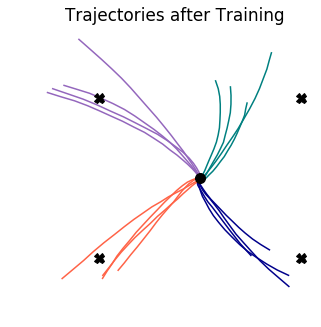

In [40]:
fig = plot_trained_trajectories(sim=sim4, tasks=[task1,task2,task3,task4],title='Trajectories after Training')


In [21]:
pr=[]
sh=[]
for h in sim4.session_probes['h']:
    fa = FactorAnalysis(n_components=2, random_state=0)
    fa.fit(h.squeeze()) # X array-like, shape (n_samples, n_features)

    private = np.sum(fa.noise_variance_)
    shared = np.sum(np.diag(np.dot(fa.components_,fa.components_.T)))
    
    pr.append(private)
    sh.append(shared)

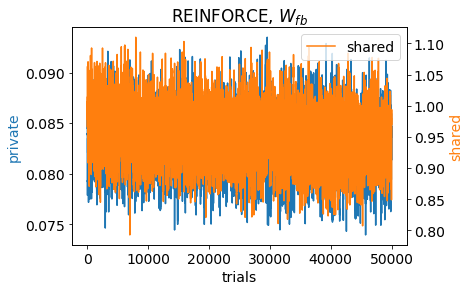

In [22]:
fig,ax = plt.subplots(1,1)
ax1=ax.twinx()
av_pr = uniform_filter1d(pr,25)
ax.plot(av_pr,label='private',color='C0')
ax.set_ylabel('private',color='C0')

av_sh = uniform_filter1d(sh,25)
ax1.plot(av_sh,label='shared',color='C1')
ax1.set_ylabel('shared',color='C1')
ax.set_xlabel('trials')
ax1.legend()
plt.title('REINFORCE, '+'$W_{fb}$')
plt.show()

# REINFORCE, train w_rec

12it [00:00, 117.04it/s]

apply_to :  ['w_rec']
online :  True


10000it [00:31, 315.38it/s]


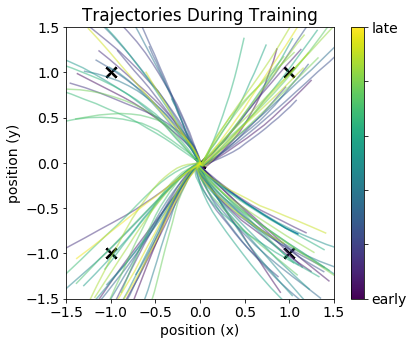

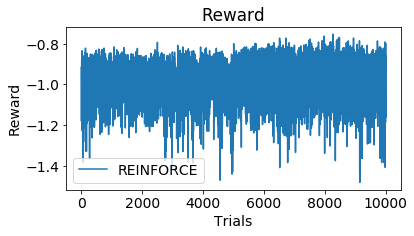

In [41]:


# Initialize RNN
net3 = RNN(params)
net3.set_weights(w_in=net0.w_in.copy(), w_rec=net0.w_rec.copy())#,w_fb=net0.w_fb.copy())
net3.set_weights(w_out=w_out1,w_m=w_out1.T,w_fb=w_out1.T)
sim3 = Simulation(net3)

reinforce = REINFORCE(net3,apply_to=['w_rec'],tau_reward=5) 
reinforce.print_params()
sim3.run_session(n_trials=10000, tasks=[task1,task2,task3,task4], learn_alg=[reinforce], probe_types=['h'], plot=True, plot_freq=100)


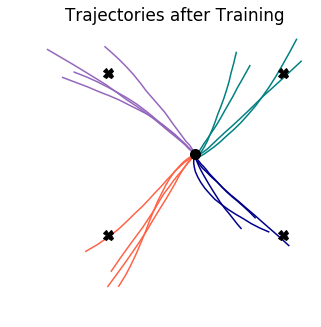

In [42]:
fig = plot_trained_trajectories(sim=sim3, tasks=[task1,task2,task3,task4],title='Trajectories after Training')


In [25]:
pr=[]
sh=[]
for h in sim3.session_probes['h']:
    fa = FactorAnalysis(n_components=2, random_state=0)
    fa.fit(h.squeeze()) # X array-like, shape (n_samples, n_features)

    private = np.sum(fa.noise_variance_)
    shared = np.sum(np.diag(np.dot(fa.components_,fa.components_.T)))
    
    pr.append(private)
    sh.append(shared)

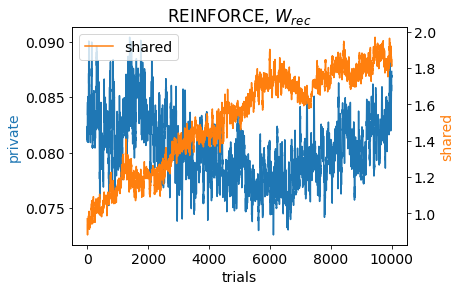

In [26]:
fig,ax = plt.subplots(1,1)
ax1=ax.twinx()
av_pr = uniform_filter1d(pr,25)
ax.plot(av_pr,label='private',color='C0')
ax.set_ylabel('private',color='C0')

av_sh = uniform_filter1d(sh,25)
ax1.plot(av_sh,label='shared',color='C1')
ax1.set_ylabel('shared',color='C1')
ax.set_xlabel('trials')
ax1.legend()
plt.title('REINFORCE, '+'$W_{rec}$')
plt.show()